Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run).

Do not remove any cell from the notebook you downloaded. If you need you can add any number of cells (and remove them if not more necessary). 

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebook!!!

Fill in your name and id number (numero matricola) below:

In [1]:
NAME = "Jacopo Andreoli" 
ID_number = int("2011655") 

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

# HOMEWORK #4
Unsupervised learning
In this notebook we are going to explore the use of unsupervised clustering methods.

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs

In [3]:
# TODO 1: Write a function to compute the pdf of a gaussian random vector, you just need to apply its definition.

def gv_normalizing_const(sigma : np.ndarray) -> np.float64:
    '''
    Function to compute the normalization coefficient of a vector valued Gaussian distribution.
    :param sigma: Covariance of the Gaussian random vector (d x d Positive Definite matrix). 
    '''
    # YOUR CODE HERE
    normalizing_const=1/(np.sqrt(((np.power(2*(np.pi),sigma.shape[0])))*np.linalg.det(sigma)))
    return normalizing_const

def gaussian_pdf(x : np.ndarray, mu : np.ndarray, sigma : np.ndarray) -> np.ndarray:
    '''
    Function to compute the pdf of a vector valued gaussian distribution on the location x given its parameters: 
    mu and sigma. We are assuming sigma is invertible (you do not need to check its invertibility). For simplicity
    return the pdf with shape (1,1), this should be the shape you get after the quadratic form computation. 
    '''
    # YOUR CODE HERE
    x_mean=x-mu
    moltiplication=np.matmul(x_mean.T,np.linalg.inv(sigma))
    unnomrmalized_pdf= np.exp(-(1/2)*(np.matmul(moltiplication, x_mean)))
    return gv_normalizing_const(sigma) * unnomrmalized_pdf

In [4]:
assert type(gv_normalizing_const(np.array([[2.]]))) == np.float64
# Test on scalar case
x = np.array([[1.]])
mean, cov = np.array([[2.5]]), np.array([[0.5]])
assert np.isclose(multivariate_normal.pdf(1, mean=mean, cov=cov), gaussian_pdf(x, mean, cov), atol=1e-3)

# Test on vector valued case
mean, temp = np.random.normal(2, 3, 2).reshape(-1,1), np.random.normal(2, 3, 4).reshape(2,2)
x = np.random.normal(2, 3, 2).reshape(-1,1)
cov = temp @ temp.T
hand_pdf = gaussian_pdf(x, mean, cov)
scipy_pdf = multivariate_normal.pdf(x.reshape(1,-1)[0], mean.reshape(1,-1)[0], cov)
assert np.isclose(hand_pdf, scipy_pdf, atol=1e-4)


Let's load a 1-D dataset which does not contain any label. It has been generated using K clusters. Can you tell 
how many clusters have been used by looking at the scatter plot?

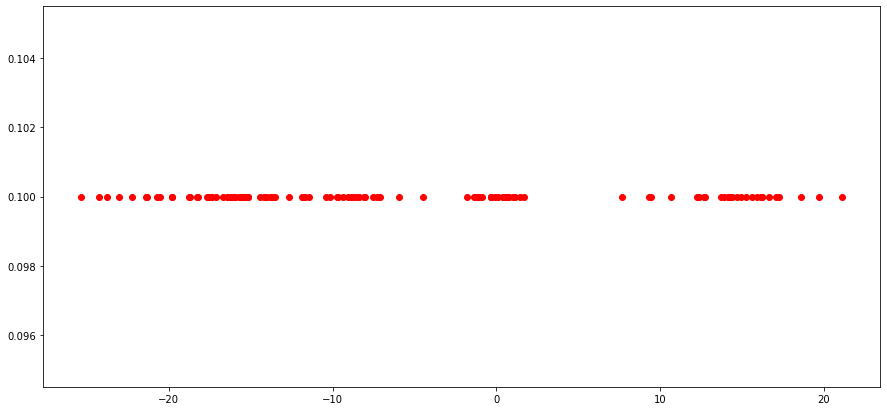

In [5]:
url = 'https://raw.githubusercontent.com/LucaZancato/ML2020-2021/main/HW_4/1_D_dataset.csv'
data = np.array(pd.read_csv(url, sep=';'))

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color='r')

It's not trivial to judge how many clusters are present. Such an issue is present also in the case of EM on GMM (the one we are going to implement) and Kmeans: for both of these algorithms the number of clusters is fixed a priori, it is a parameter (hyper-parameter) we must decide before processing any datum.
Usually in order to achieve satisfactory clustering one needs to try with different number of classes and validate which is the best number. 

For now let's make it simple and let's consider the dataset has 3 clusters. 
In the following cell we shall parametrize 3 Gaussian random variables specifiying both means, covariances and mixing probabilities. Take a second to understand the way these parameters are stored, since the EM implementation is built on this notation. For now, means, cov and mixing probabilities are choosen without any specific criterion, we will see how EM applied to GMM will provide us a suboptimal set of means, covariances and mixing probabilities.

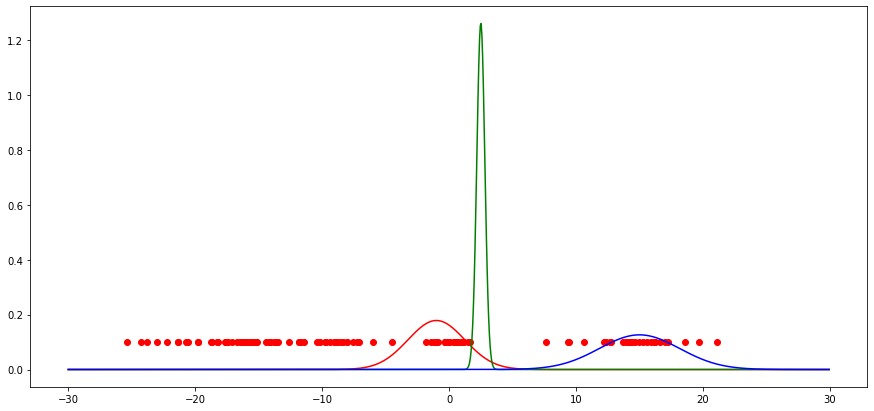

In [6]:
means = np.array([[-1],[2.5],[15]])      # KxF
covs  = np.array([[[5]],[[0.1]],[[10]]]) # KxFxF 
pi    = np.array([[1/2],[1/4],[1/4]])    # Kx1

X = np.linspace(-30, 30, 1000, endpoint=False).reshape(-1,1)

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color='r')
plt.plot(X, [gaussian_pdf(x, means[0], covs[0]) for x in X], color='r')
plt.plot(X, [gaussian_pdf(x, means[1], covs[1]) for x in X], color='g')
plt.plot(X, [gaussian_pdf(x, means[2], covs[2]) for x in X], color='b')

In [7]:
# TODO 2: Write a function M_step which computes the M-step of the EM algorithm in case of a GMM. Refer 
# to the slides you can find on the moodle (in which ALL the necessary steps and expressions are present).
# Start by looking at the function "M_step" and then build all the help functions.

def update_pi(W : np.ndarray) -> np.ndarray:
    '''
    See M_step docs.
    '''
    # YOUR CODE HERE
    new_pi=np.zeros(W.shape[1])
    new_pi=(1/(W.shape[0]))*(np.sum(W,axis=0))
    return new_pi

def update_means(data : np.ndarray, W : np.ndarray) -> np.ndarray:
    '''
    See M_step docs.
    '''
    # YOUR CODE HERE
    new_means = np.zeros((W.shape[1], data.shape[1]))
    for k in range (W.shape[1]):
        new_means[k] = (np.sum(data*(W[:, k]).reshape(-1,1), axis = 0))/(np.sum(W[:, k]))
    return new_means

def update_covs(data : np.ndarray, W : np.ndarray, new_means : np.ndarray) -> np.ndarray:
    '''
    See M_step docs.
    '''
    # YOUR CODE HERE
    new_covs = np.zeros((W.shape[1], data.shape[1], data.shape[1]))
    for l in range(W.shape[1]):
        for i in range (data.shape[0]):
            new_covs[l] += np.dot((data[i] - new_means[l]).reshape(len(data[i]),1), (data[i] - new_means[l]).reshape(1, len(data[i]))) * W[i][l]
        new_covs[l] = new_covs[l] / np.sum(W[:,l])
    return new_covs

def M_step(data : np.ndarray, W : np.ndarray) -> tuple:
    '''
    Function to compute the Maximization step on a GMM model (use the expressions derived on the slides).
    :param data: Dataset N x d (d := number of features)
    :param W: Weight matrix N x K (K :=number of classes). Element in position (i,j) represents the probability of
              i-th datum to belong to class j (j-th cluster) given the current parameters: pi, means, covs
    :returns: (new_pi, new_mu, new_cov)
        WHERE:
        new_pi: Contains the mixing probabilities. Its shape is (K,)
        new_mu: Contains the new means of the GMM model. Its shape is (K, d)
        new_cov: Contains the new covariances of the GMM model. Its shape is (K, d, d)
    '''
    new_pi    = update_pi(W)
    new_means = update_means(data, W)
    new_covs  = update_covs(data, W, new_means)
    
    return new_pi, new_means, new_covs 

In [8]:
W = np.array([[0.5, 0.5, 0],[0.5, 0, 0.5]])
assert np.isclose(update_pi(W), [0.5 , 0.25, 0.25], atol=1e-4).all()
W = np.random.normal(0,1, 1000).reshape(-1, 25) # Note this W is not normalized properly, we do not care not since we are testing only the output shape is correct
assert update_pi(W).shape == (25,)
# Test on the means update function
a = np.random.normal(0,1, 80).reshape(-1, 2)
b = update_means(a, W)
assert b.shape  == (25, 2)
# Test on the covs update function
assert update_covs(a, W, b).shape == (25, 2, 2)


In [9]:
# TODO 3: Write a function E_step which computes the E-step of the EM algorithm in case of a GMM. Refer 
# to the slides you can find on the moodle (in which ALL the necessary steps and expressions are present).
def E_step(data : np.ndarray, pi : np.ndarray, means : np.ndarray, covs : np.ndarray):
    '''
    Function to compute the Expectation step on a GMM model (use the expressions derived on the slides) given 
    the current values of the GMM parameters: pi, means, covs.
    :param data:  Same as M_step function.
    :param pi:    Same as M_step function.
    :param means: Same as M_step function.
    :param covs:  Same as M_step function.
    :returns: W, which is updated using the parameters of the GMM: pi, means, covs. W must be normalized (see 
              slides)
    '''
    # YOUR CODE HERE
    W=np.ndarray(shape=(data.shape[0], means.shape[0]))
    denominator=0
    for i in range(means.shape[0]):
        for j in range(data.shape[0]):
            numerator=gaussian_pdf(data[j], means[i], covs[i])*pi[i]
            for k in range(means.shape[0]):
                denominator=gaussian_pdf(data[j], means[k], covs[k])*pi[k]+denominator
            W[j][i]=numerator/denominator
            denominator=0
            numerator=0
    return W

In [10]:
assert E_step(data, pi, means, covs).shape == (119, 3)
assert np.isclose(np.sum(E_step(data, pi, means, covs).sum(1) - 1), 0, atol=1e-4)

In [11]:
# TODO 4: Write a function to randomly initialize the parameters of a GMM. This is necessary to start with the 
# EM iterations. 

def randomly_initialize_W(data : np.ndarray, num_classes : int) -> np.ndarray:
    '''
    See random_init function docs.
    '''
    # YOUR CODE HERE
    W=np.zeros((data.shape[0], num_classes))
    random_index=np.arange(0,data.shape[0],1)
    np.random.shuffle(random_index)
    number=int(data.shape[0]/num_classes) 
    for i in range(num_classes):
        for j in (random_index[(i*number):(i*number+number)]):
            W[j][i]=1
    if((data.shape[0]-num_classes*number)!= 0):
        for i in (random_index[(num_classes*number):]):
            W[i][1]=1
    return W

def random_init(data : np.ndarray, num_classes : int) -> np.ndarray:
    '''
    Function to initialize W and GMM parameters. W is generated assigning randomly each datapoint only to one 
    cluster. We require to assign the same number of points for each cluster (even this is not striclty necessary
    to run the EM algorithm on GMM). If the number of data is not exactly divisible by the number of clusters 
    assign the exceeding data to one single class (it does not matter which one). 
    See M_step docs for details on W, interpretation and required shape.
    '''
    # Initialize W
    W = randomly_initialize_W(data, num_classes)
    # Use M_step to get GMM parameters
    pi, means, covs = M_step(data, W)
    return W, pi, means, covs

In [12]:
assert (randomly_initialize_W(np.random.normal(0,1, 100).reshape(-1,10), 5).sum(0) == 2).all()
assert (randomly_initialize_W(np.random.normal(0,1, 100).reshape(-1,5), 2).sum(0) == 10).all()
assert (randomly_initialize_W(np.random.normal(0,1, 100).reshape(-1,5), 3).sum(0) -6 == 2).any()

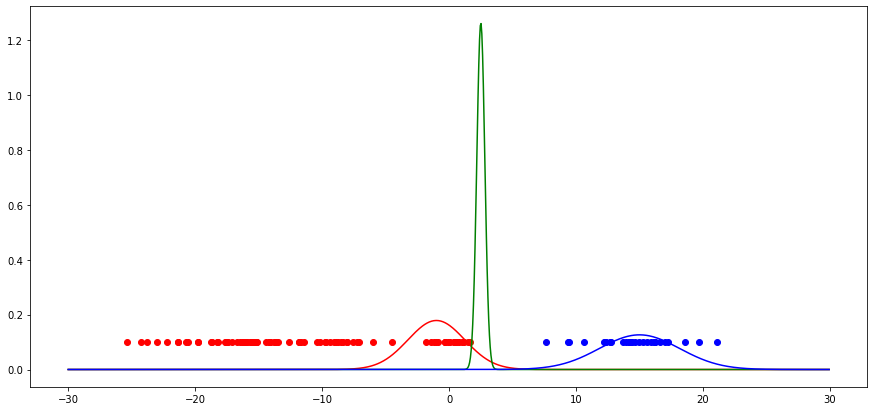

In [13]:
# Let's evaluate the class probability of each datum given current pi, means and covs. 
# Since we have 3 clusters we shall color code (rgb) each datum according to the class probabilities. Note that 
# it is not very likely to have a datum coming from the central (very peaked) distribution. 
W = E_step(data, pi, means, covs)

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color=np.array([W[i][0], W[i][1], W[i][2]]))
plt.plot(X, [gaussian_pdf(x, means[0], covs[0]) for x in X], color='r')
plt.plot(X, [gaussian_pdf(x, means[1], covs[1]) for x in X], color='g')
plt.plot(X, [gaussian_pdf(x, means[2], covs[2]) for x in X], color='b')

In [14]:
# TODO 5: compute the log likelihood of an iid dataset under a GMM model.
def log_likelihood_GMM(data : np.ndarray, pi : np.ndarray, means : np.ndarray, covs : np.ndarray) -> float:
    '''
    Function to compute the log likelihood for a set of iid observations under a GMM. Use the function you built
    before "gaussian_pdf" to compute the likelihood. 
    :param data: N x d matrix containing a set of N iid data of dimension d
    :param pi:    Same as M_step function.
    :param means: Same as M_step function.
    :param covs:  Same as M_step function.
    :new_pi: Contains the mixing probabilities. Its shape is (K,)
        new_mu: Contains the new means of the GMM model. Its shape is (K, d)
        new_cov: Contains the new covariances of the GMM model. Its shape is (K, d, d)
    '''
    # YOUR CODE HERE
    logger=0
    log_likelihood=0.0
    for i in range(data.shape[0]):
        logger=0
        for j in range(pi.shape[0]):
            logger=float(pi[j])*(gaussian_pdf(data[i], means[j], covs[j]))+logger
        log_likelihood=np.log(logger)+log_likelihood
    return log_likelihood

In [15]:
assert type(log_likelihood_GMM(data, pi, means, covs)) == np.float64

Iteration 0, log likelihood -472.8637,  delta log likelihood 0.4543
Iteration 1, log likelihood -472.4492,  delta log likelihood 0.4145
Iteration 2, log likelihood -471.6494,  delta log likelihood 0.7997
Iteration 3, log likelihood -469.9505,  delta log likelihood 1.6989
Iteration 4, log likelihood -466.6563,  delta log likelihood 3.2942
Iteration 5, log likelihood -462.2547,  delta log likelihood 4.4016
Iteration 6, log likelihood -458.1378,  delta log likelihood 4.1170
Iteration 7, log likelihood -454.9480,  delta log likelihood 3.1898
Iteration 8, log likelihood -453.3321,  delta log likelihood 1.6159
Iteration 9, log likelihood -452.7345,  delta log likelihood 0.5976
Iteration 10, log likelihood -452.4723,  delta log likelihood 0.2623
Iteration 11, log likelihood -452.3080,  delta log likelihood 0.1642
Iteration 12, log likelihood -452.1782,  delta log likelihood 0.1298
Iteration 13, log likelihood -452.0657,  delta log likelihood 0.1125
Iteration 14, log likelihood -451.9657,  del

Text(0, 0.5, 'Log likelihood')

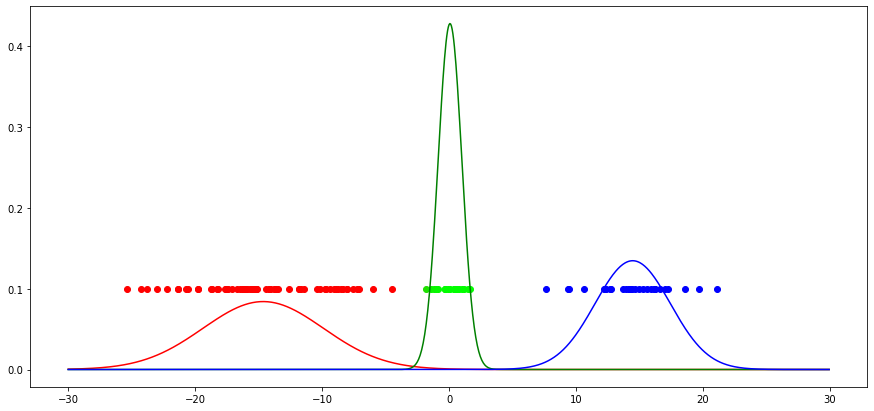

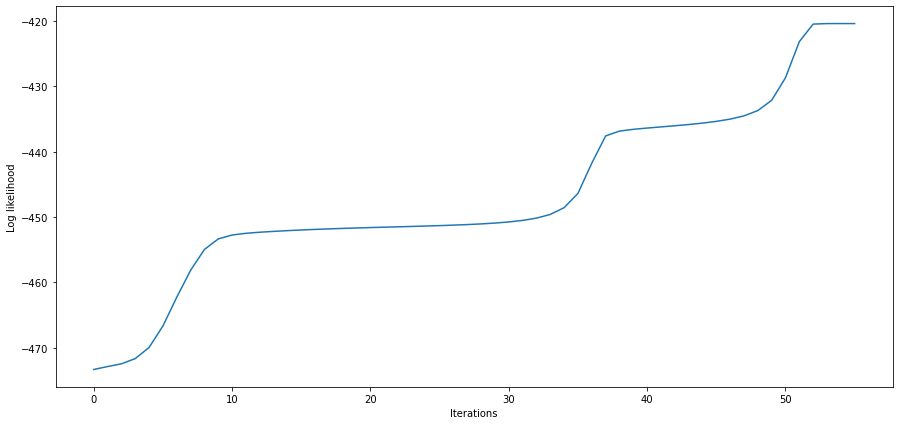

In [16]:
# TODO 6: Write a function to run the EM on GMM using the building blocks we created so far. Then test it on the 
# data we used so far (choose a meaningful max_iter, you do not need to exceed). 
def run_EM_on_GMM(data : np.ndarray, number_clusters : int, max_iter : int, epsilon : float = 1e-3,
                  plot_intermediate : bool = False) -> tuple:
    '''
    Function to run GMM on a given dataset and a given number of clusters. The termination conditions of the 
    iterative algorithm take into account either a specified max number of iterations or the improvement of the 
    log likelihood (if the log likelihood does not improve more than epsilon in two successive iterations we stop).
    :param data: N x d matrix containing a set of N iid data of dimension d
    :param number_clusters: # of clusters (information we have a priori, before starting the EM)
    :param max_iter: Maximum number of iterations allowed to the EM.
    :param epsilon: Threshold on the improvement of the log likelihood
    :param plot_intermediate: Boolean used to plot intermediate GMM for 2-d datasets (you do not need to implement
                              anything).
    :returns: (W, pi, means, covs, log_likelihood_train)
        WHERE:
        W:     Optimal W     after EM reaches termination condition (same shape as M_step function).
        pi:    Optimal pi    after EM reaches termination condition (same shape as M_step function).
        means: Optimal means after EM reaches termination condition (same shape as M_step function).
        covs:  Optimal covs  after EM reaches termination condition (same shape as M_step function).
        log_likelihood_train: log likelihoods obtained during training (saved using a list). 
    '''
    W, pi, means, covs = random_init(data, number_clusters)
    log_likelihood_train = [log_likelihood_GMM(data, pi, means, covs)]
    num_iter = 0
    # Used to plot 2-d data
    if plot_intermediate:
        x_max = np.max(np.abs(X))
        x, y = np.mgrid[-x_max:x_max:.05, -x_max:x_max:.05]
        pos = np.dstack((x, y))
    
    while (True): 
        # Iterate with E-Step and M-step
        # YOUR CODE HERE
        W = E_step(data,pi,means,covs)
        pi, means, covs = M_step(data, W) 
        # Save log likelihood given current GMM parameters
        log_likelihood_train.append(log_likelihood_GMM(data, pi, means, covs)) 

        if plot_intermediate:
            # Plot scatter plot of training data and corresponding clusters    
            fig = plt.figure(figsize=(15,7))
            for k in range(0, number_clusters):
                plt.contour(x, y, multivariate_normal(means[k], covs[k]).pdf(pos))
            plt.scatter(data[0:,0], data[0:,1])
            plt.title(f'Iteration {num_iter}')
            
        print(f'Iteration {num_iter}, log likelihood {log_likelihood_train[-1]:.4f}, ' 
              f' delta log likelihood {(log_likelihood_train[-1] - log_likelihood_train[-2]):.4f}')
        num_iter += 1 
        
        # Use proper termination conditions, on: number of iteration or log likelihood improvement (use the 
        # break statement to stop while cycle)
        # YOUR CODE HERE
        if(num_iter == max_iter):
            break
        if(abs(log_likelihood_train[-1] - log_likelihood_train[-2])<epsilon):
            break
        
    return W, pi, means, covs, log_likelihood_train

# Let's try our implementation of the EM algorithm
max_iter = None
# YOUR CODE HERE
max_iter = 100
W, pi, means, covs, log_likelihood_train = run_EM_on_GMM(data, 3, max_iter, plot_intermediate=False)

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color=np.array([W[i][0], W[i][1], W[i][2]]))
plt.plot(X, [gaussian_pdf(x, means[0], covs[0]) for x in X], color='r')
plt.plot(X, [gaussian_pdf(x, means[1], covs[1]) for x in X], color='g')
plt.plot(X, [gaussian_pdf(x, means[2], covs[2]) for x in X], color='b')

plt.figure(figsize=(15,7))
plt.plot(log_likelihood_train)
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

In [17]:
a, b, c, d, e = run_EM_on_GMM(data, 3, 10, plot_intermediate=False)
assert a.shape == (119, 3)
assert b.shape == (3,)
assert c.shape == (3, 1)
assert d.shape == (3, 1, 1)

Iteration 0, log likelihood -471.3846,  delta log likelihood 1.5686
Iteration 1, log likelihood -469.3139,  delta log likelihood 2.0708
Iteration 2, log likelihood -465.6550,  delta log likelihood 3.6589
Iteration 3, log likelihood -461.2685,  delta log likelihood 4.3864
Iteration 4, log likelihood -457.3553,  delta log likelihood 3.9132
Iteration 5, log likelihood -454.4815,  delta log likelihood 2.8738
Iteration 6, log likelihood -453.1217,  delta log likelihood 1.3599
Iteration 7, log likelihood -452.6274,  delta log likelihood 0.4942
Iteration 8, log likelihood -452.4066,  delta log likelihood 0.2208
Iteration 9, log likelihood -452.2665,  delta log likelihood 0.1402


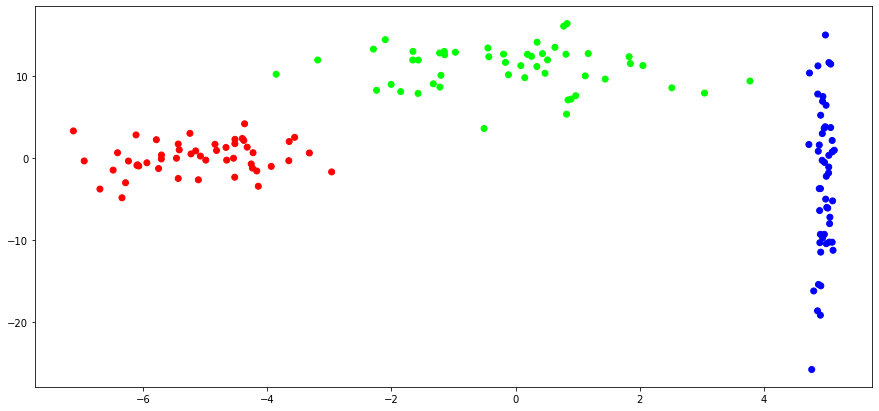

In [18]:
# We shall now use a 2-D dataset.
K = 3
clusters_cov = [[1,2], [2,3], [0.1,10]]
centers = [[-5, 0], [0, 10.5], [5, -1]]
X, Y = make_blobs(cluster_std=clusters_cov, centers=centers, random_state=ID_number, n_samples=150, shuffle=True)

colormap = np.array(['red', 'lime', 'blue'])

plt.figure(figsize=(15,7))
plt.scatter(X[:,0], X[:,1], c = colormap[Y])

Iteration 0, log likelihood -948.7894,  delta log likelihood 4.0688
Iteration 1, log likelihood -940.1860,  delta log likelihood 8.6034
Iteration 2, log likelihood -925.3062,  delta log likelihood 14.8798
Iteration 3, log likelihood -904.6732,  delta log likelihood 20.6330
Iteration 4, log likelihood -881.6399,  delta log likelihood 23.0333
Iteration 5, log likelihood -858.6376,  delta log likelihood 23.0023
Iteration 6, log likelihood -838.9789,  delta log likelihood 19.6588
Iteration 7, log likelihood -805.8305,  delta log likelihood 33.1484
Iteration 8, log likelihood -741.9478,  delta log likelihood 63.8826
Iteration 9, log likelihood -719.9942,  delta log likelihood 21.9536
Iteration 10, log likelihood -715.9140,  delta log likelihood 4.0801
Iteration 11, log likelihood -713.0255,  delta log likelihood 2.8886
Iteration 12, log likelihood -710.6207,  delta log likelihood 2.4048
Iteration 13, log likelihood -707.9354,  delta log likelihood 2.6853
Iteration 14, log likelihood -704.31

<ipython-input-16-21823d17499d>:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15,7))


Iteration 20, log likelihood -682.5323,  delta log likelihood 0.0000


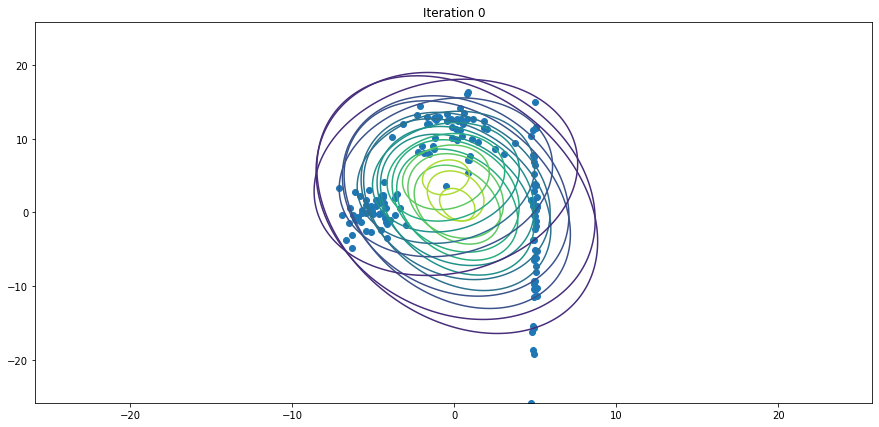

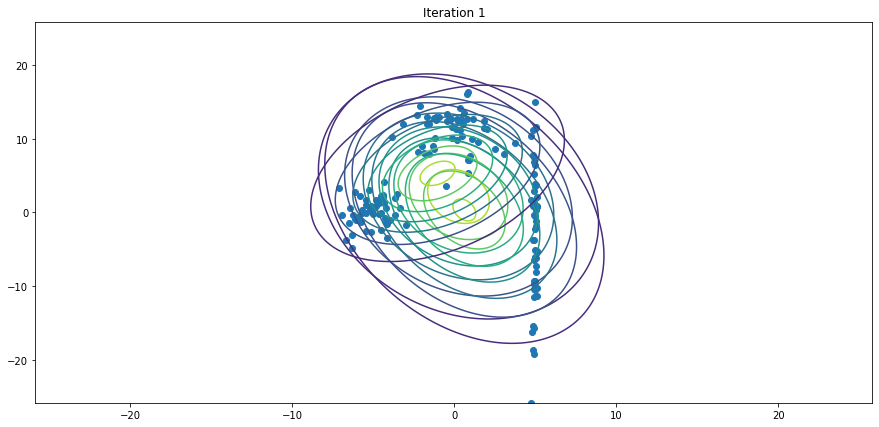

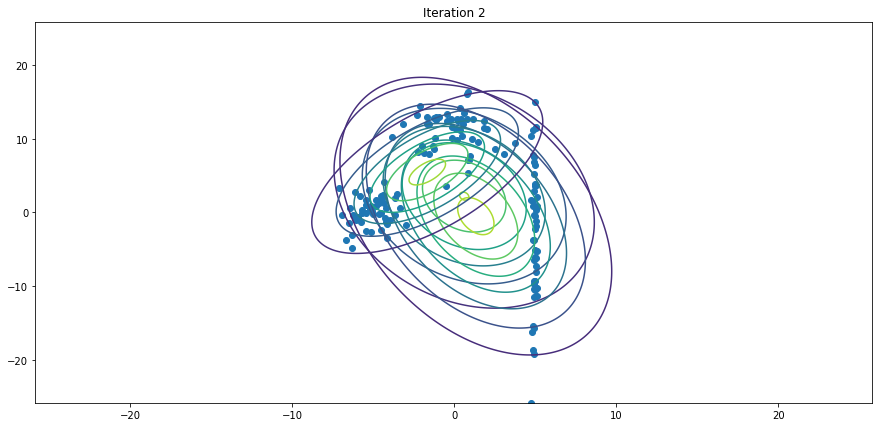

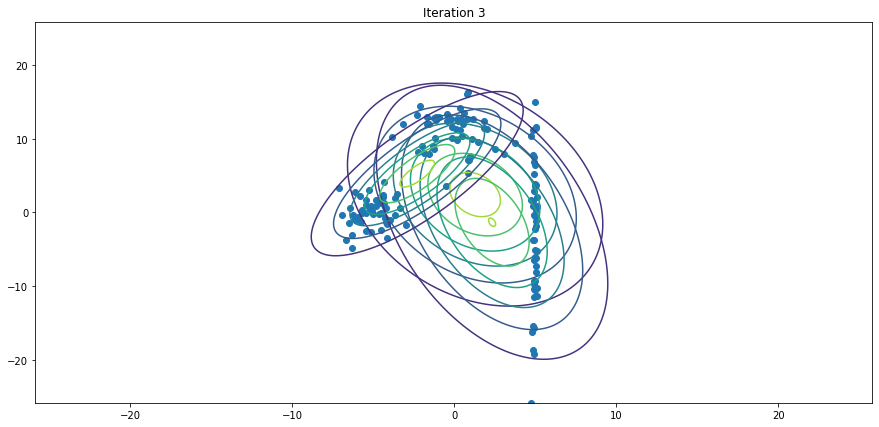

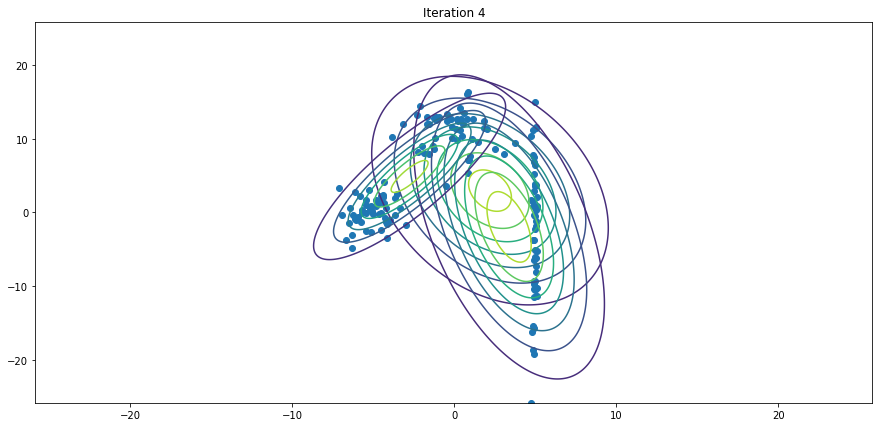

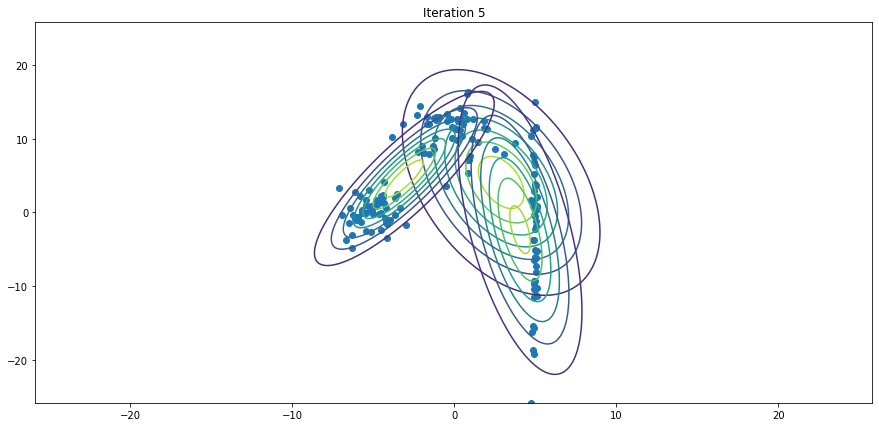

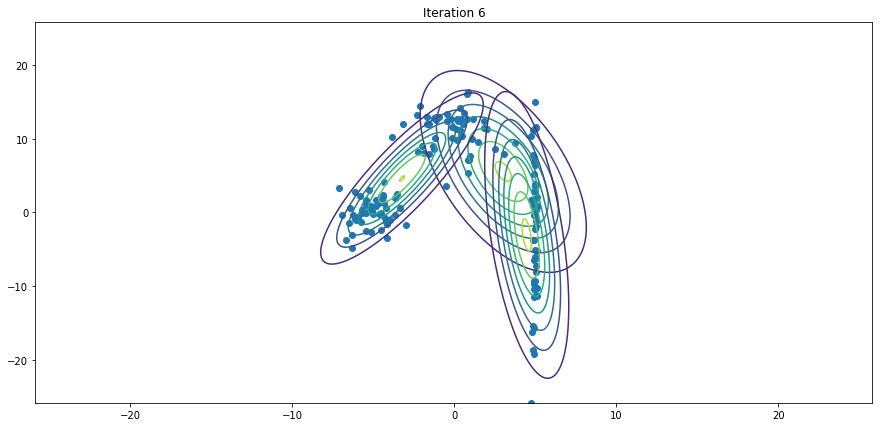

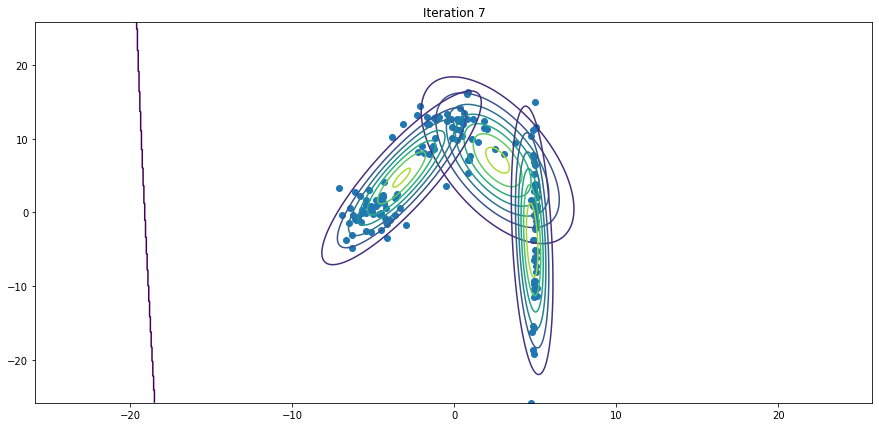

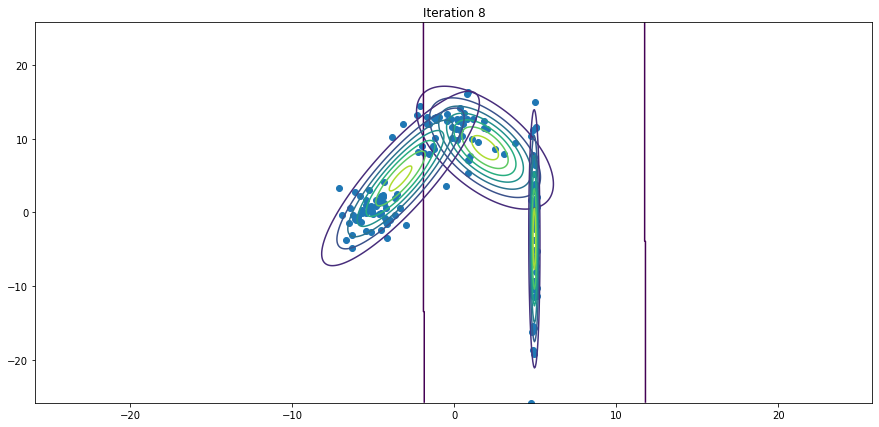

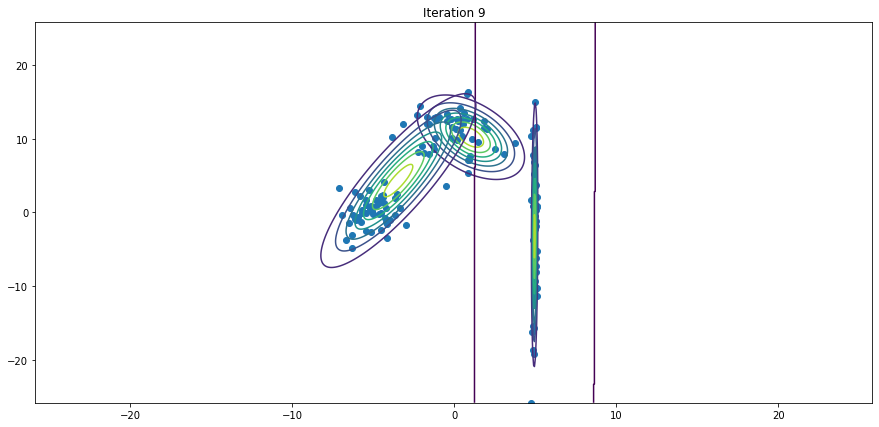

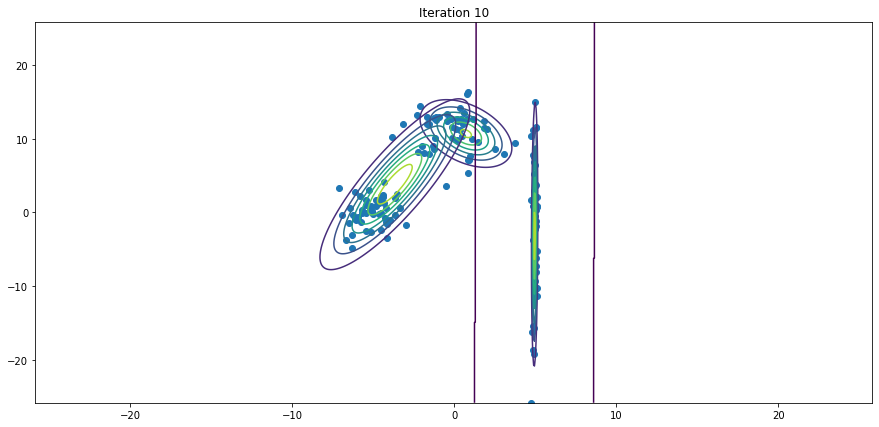

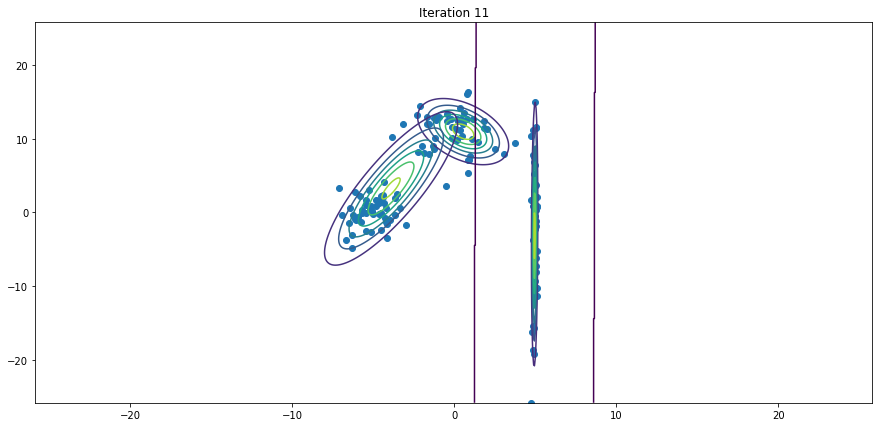

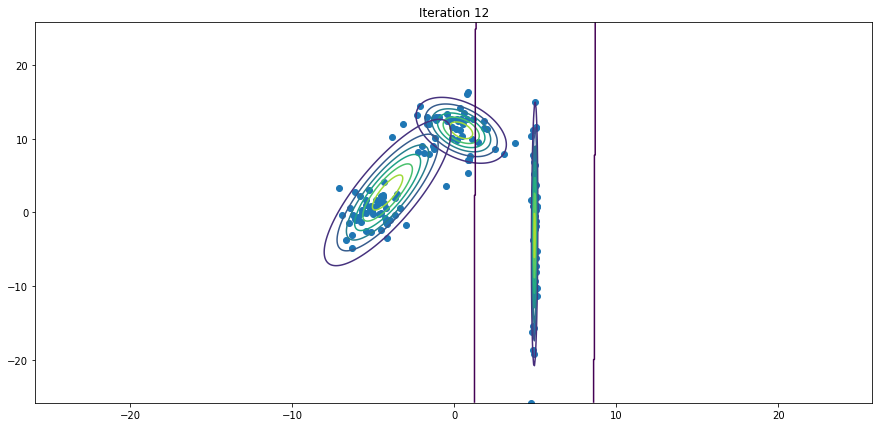

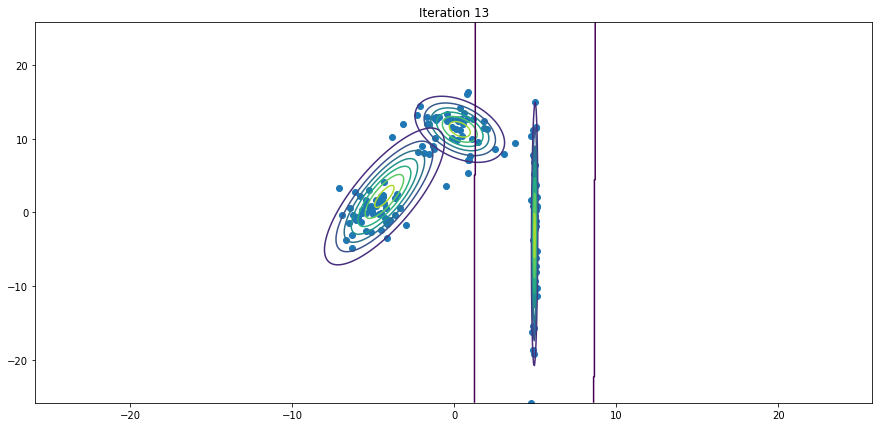

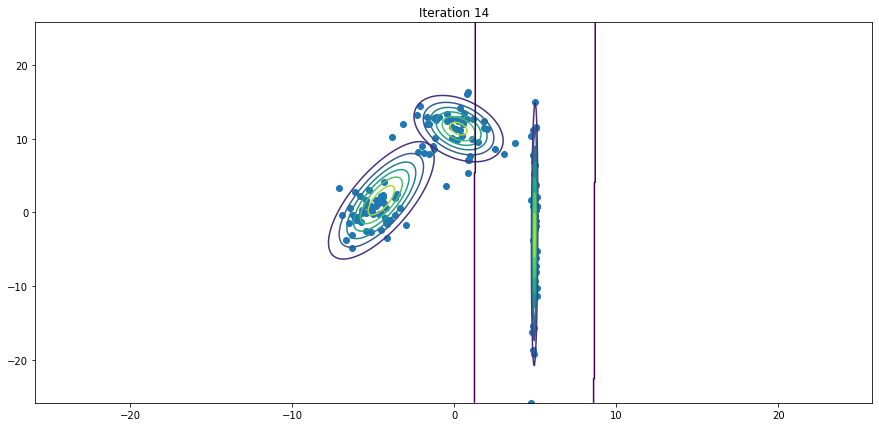

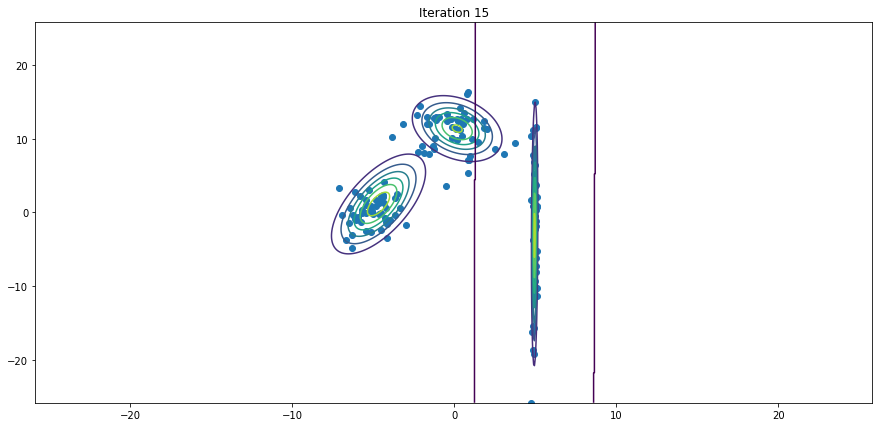

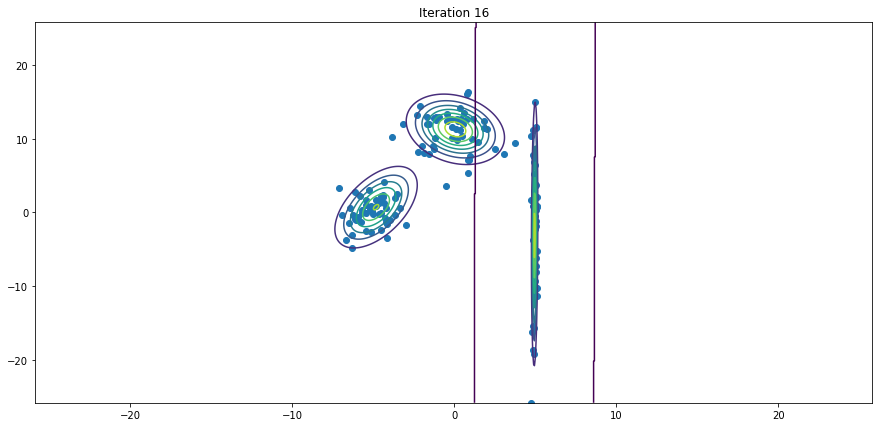

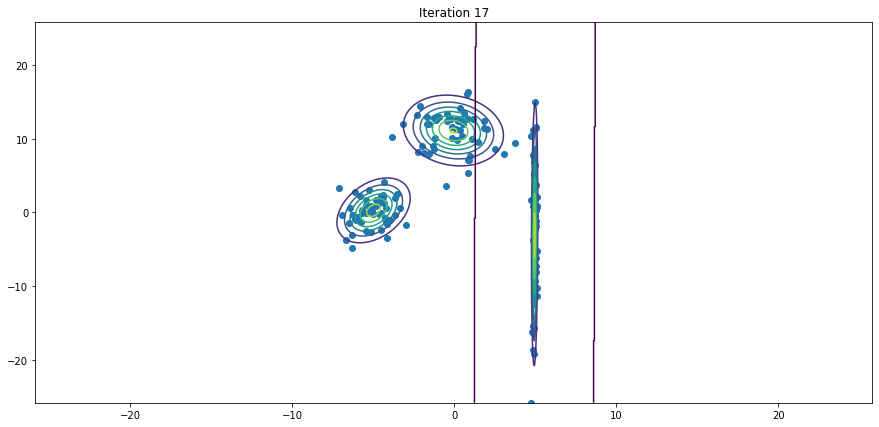

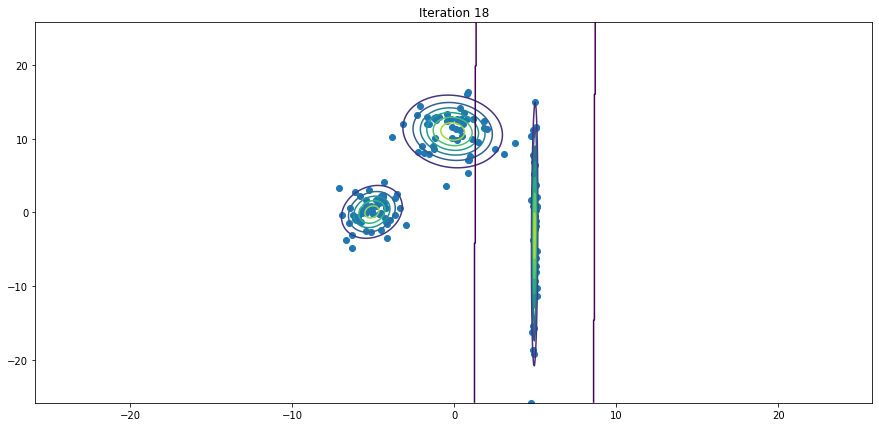

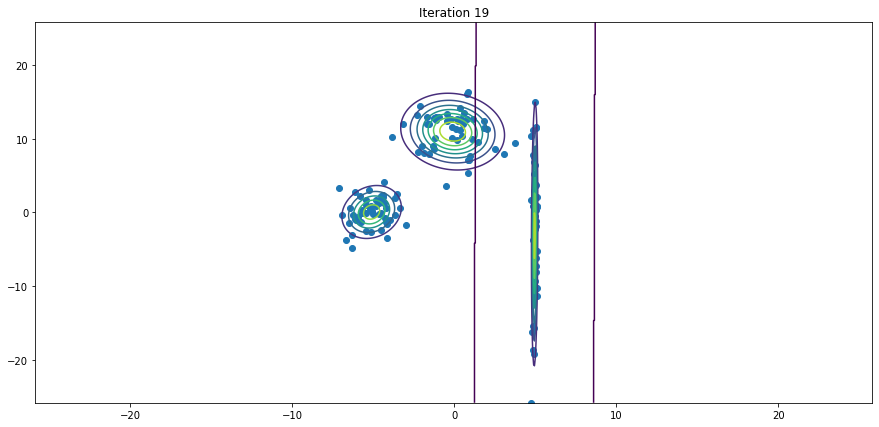

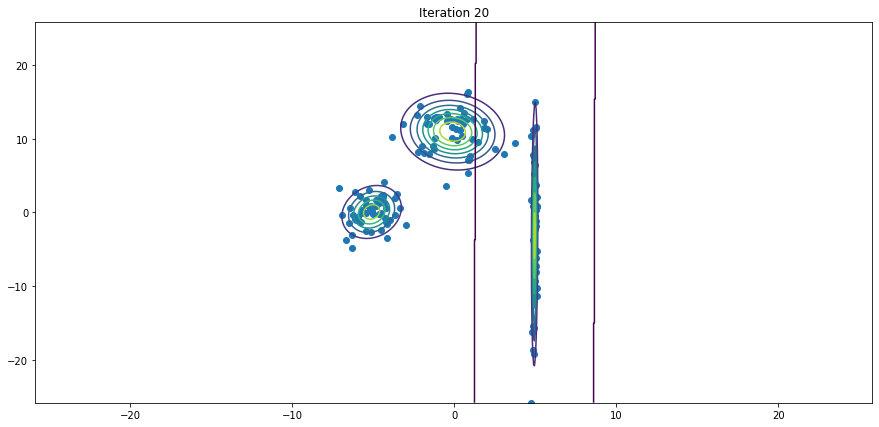

In [19]:
# Depending on your implementation this cell might take a while to run... (this is mainly due to the plots)
W, pi, means, covs, log_likelihood_train = run_EM_on_GMM(X, K, 150, plot_intermediate=True)

Text(0, 0.5, 'Log likelihood')

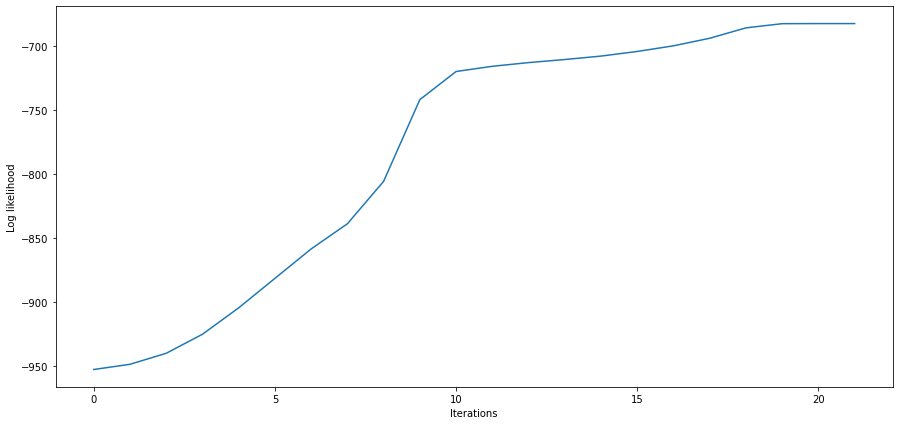

In [20]:
plt.figure(figsize=(15,7))
plt.plot(log_likelihood_train)
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

# TODO 7: explain the results you got (max 10 lines)

1-D dataset:
- Compare plots in to do 4 with the ones in to do 6, what has changed? Is EM providing us a meaningful clustering? 

2-D dataset:
- Why is the log likelihood monotonically increasing? Is this what you expect from the theory? Compare both log likelihood trajectory and 2-d plots.
- Is delta log likelihood monotonically going to zero?  
- Which termination criterion is met first?

(Answer in the next cell, no need to add code)

In [21]:
# YOUR CODE HERE

# The two plots represent the probabilities of each data to belong in each clusters. However, the first resort to randomly 
# initialize Gaussian distribution function, while the second refer to the most likely Gaussian distribution obtained through 
# EM algorithm, for three clusters. The log likelyhood is monotonically increasing (something that I expected from theory)
# since the maximization step deals with a sequence of function built to have two properties: 
# they touch the log likelihood in the point that we are considering and the log likelihood is an upper bound for them. 
# Comparing the two plots we can observe that the accuracy associated to the clusters increase with the log likelihood function.
# The delta log likelihood function doesn't monotonically going to zero, since the improvement that we can have at one step can 
# be better/worse than the next step. The termination criterion met first, while running the EM algorithm, is referred to the
# threshold associated to the improvement of log likelyhood at every iteration.


In [22]:
# What is the effect of a wrong choice of the number of classes?
centers = [[-2, 0], [0, 3], [2, -1]]
X, Y = make_blobs(cluster_std=clusters_cov, centers=centers, random_state=20, n_samples=150, shuffle=True)

Ks = [2, 3, 4, 5, 6]
results = []
for k in Ks:
    results.append(run_EM_on_GMM(X, k, 150, plot_intermediate=False))

Iteration 0, log likelihood -801.4208,  delta log likelihood 0.7300
Iteration 1, log likelihood -799.4866,  delta log likelihood 1.9342
Iteration 2, log likelihood -794.8249,  delta log likelihood 4.6617
Iteration 3, log likelihood -788.4480,  delta log likelihood 6.3769
Iteration 4, log likelihood -781.5418,  delta log likelihood 6.9062
Iteration 5, log likelihood -773.3099,  delta log likelihood 8.2319
Iteration 6, log likelihood -762.7842,  delta log likelihood 10.5256
Iteration 7, log likelihood -749.0849,  delta log likelihood 13.6993
Iteration 8, log likelihood -736.2122,  delta log likelihood 12.8728
Iteration 9, log likelihood -729.0685,  delta log likelihood 7.1436
Iteration 10, log likelihood -722.2055,  delta log likelihood 6.8630
Iteration 11, log likelihood -706.4439,  delta log likelihood 15.7616
Iteration 12, log likelihood -687.9217,  delta log likelihood 18.5223
Iteration 13, log likelihood -677.1425,  delta log likelihood 10.7792
Iteration 14, log likelihood -674.7317

Iteration 51, log likelihood -657.3323,  delta log likelihood 0.0209
Iteration 52, log likelihood -657.3125,  delta log likelihood 0.0199
Iteration 53, log likelihood -657.2936,  delta log likelihood 0.0188
Iteration 54, log likelihood -657.2759,  delta log likelihood 0.0178
Iteration 55, log likelihood -657.2591,  delta log likelihood 0.0168
Iteration 56, log likelihood -657.2434,  delta log likelihood 0.0157
Iteration 57, log likelihood -657.2287,  delta log likelihood 0.0147
Iteration 58, log likelihood -657.2150,  delta log likelihood 0.0137
Iteration 59, log likelihood -657.2023,  delta log likelihood 0.0127
Iteration 60, log likelihood -657.1906,  delta log likelihood 0.0117
Iteration 61, log likelihood -657.1800,  delta log likelihood 0.0107
Iteration 62, log likelihood -657.1703,  delta log likelihood 0.0097
Iteration 63, log likelihood -657.1615,  delta log likelihood 0.0088
Iteration 64, log likelihood -657.1535,  delta log likelihood 0.0079
Iteration 65, log likelihood -657.

Iteration 88, log likelihood -652.4635,  delta log likelihood 0.7149
Iteration 89, log likelihood -651.9692,  delta log likelihood 0.4943
Iteration 90, log likelihood -651.9488,  delta log likelihood 0.0204
Iteration 91, log likelihood -651.9453,  delta log likelihood 0.0036
Iteration 92, log likelihood -651.9434,  delta log likelihood 0.0018
Iteration 93, log likelihood -651.9423,  delta log likelihood 0.0011
Iteration 94, log likelihood -651.9416,  delta log likelihood 0.0007
Iteration 0, log likelihood -787.1365,  delta log likelihood 8.0847
Iteration 1, log likelihood -779.0308,  delta log likelihood 8.1057
Iteration 2, log likelihood -769.8038,  delta log likelihood 9.2270
Iteration 3, log likelihood -757.9432,  delta log likelihood 11.8606
Iteration 4, log likelihood -739.0162,  delta log likelihood 18.9270
Iteration 5, log likelihood -707.9886,  delta log likelihood 31.0276
Iteration 6, log likelihood -680.5618,  delta log likelihood 27.4268
Iteration 7, log likelihood -670.2614

Iteration 112, log likelihood -646.4081,  delta log likelihood 0.0155
Iteration 113, log likelihood -646.3911,  delta log likelihood 0.0170
Iteration 114, log likelihood -646.3722,  delta log likelihood 0.0189
Iteration 115, log likelihood -646.3511,  delta log likelihood 0.0212
Iteration 116, log likelihood -646.3270,  delta log likelihood 0.0240
Iteration 117, log likelihood -646.2993,  delta log likelihood 0.0278
Iteration 118, log likelihood -646.2667,  delta log likelihood 0.0326
Iteration 119, log likelihood -646.2275,  delta log likelihood 0.0392
Iteration 120, log likelihood -646.1791,  delta log likelihood 0.0484
Iteration 121, log likelihood -646.1172,  delta log likelihood 0.0619
Iteration 122, log likelihood -646.0344,  delta log likelihood 0.0828
Iteration 123, log likelihood -645.9169,  delta log likelihood 0.1175
Iteration 124, log likelihood -645.7366,  delta log likelihood 0.1803
Iteration 125, log likelihood -645.4352,  delta log likelihood 0.3015
Iteration 126, log l

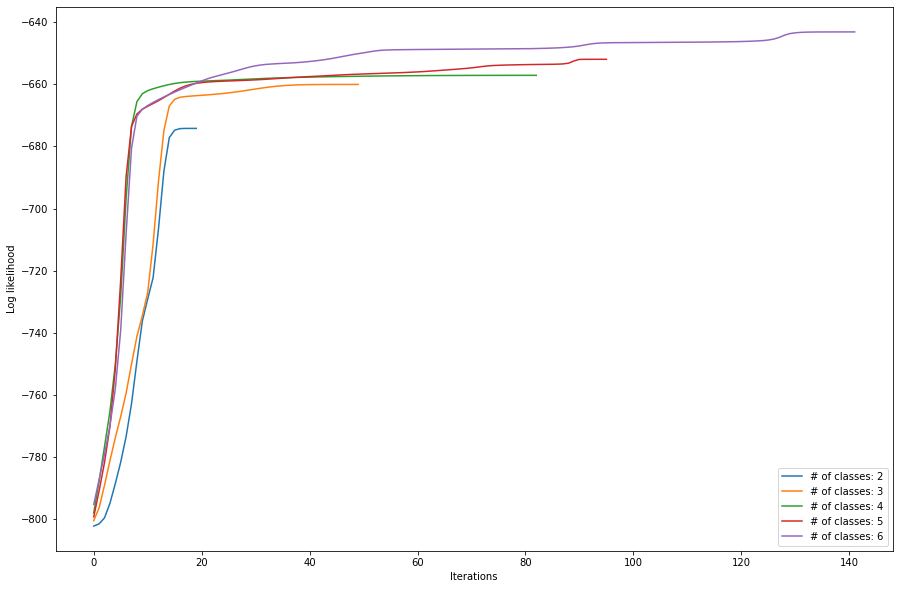

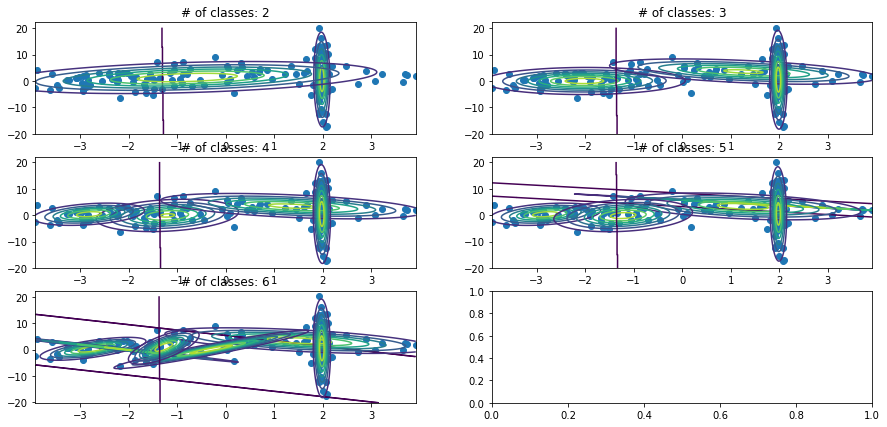

In [23]:
# Let's plot the log likelihood trajectories and the final 2-d Clustering
plt.figure(figsize=(15,10))
for res, k in zip(results, Ks): 
    plt.plot(np.array(res[-1]), label=f'# of classes: {k}')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

x_max, y_max = np.max(np.abs(X[:,0])), np.max(np.abs(X[:,1]))
x, y = np.mgrid[-x_max:x_max:.01, -y_max:y_max:.01]
pos = np.dstack((x, y))

fig, axes = plt.subplots(3, 2, figsize=(15,7))
# Plot scatter plot of training data and corresponding clusters    
for (_, pi, means, covs, _), K, ax in zip(results, Ks, axes.reshape(-1,)): 
    for k in range(K):
        ax.contour(x, y, multivariate_normal(means[k], covs[k]).pdf(pos), )
    ax.scatter(X[0:,0], X[0:,1])
    ax.set_title(f'# of classes: {K}')

# MNIST clustering

Let's apply GMM to a slightly more complex dataset: MNIST. In the following we shall use the sklearn implementation of the EM. Once we fit the GMM we shall visualize the centers in order to evaluate whether the clustering algorithm came up with a meaningful solution (in an ideal scenario we'd expect to have each center representing one single digit).

In [24]:
from sklearn.datasets import fetch_openml
from sklearn.mixture import GaussianMixture

X, Y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255.

from sklearn.model_selection import train_test_split

m_t = 5000
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=m_t/len(Y), random_state=ID_number, 
                                                    stratify=Y)

# Function to plot a digit and print the corresponding label
def plot_digit(vect_img, ax, cluster_id=None):
    ax.set_title(f'Cluster ID: {cluster_id}')
    ax.imshow(
        vect_img.reshape(28,28),
        cmap          = 'gray',
        interpolation = "nearest"
    )

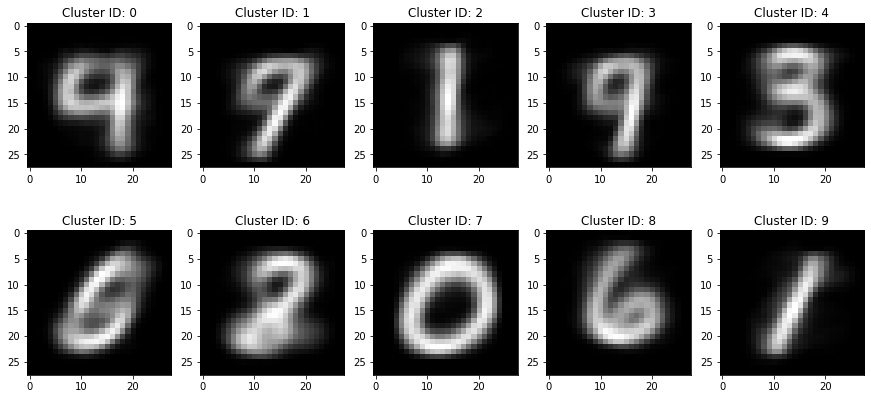

In [25]:
# TODO 8: use GaussianMixture from skelearn to cluster x_train and then predict the labels.
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

K = 10
# When you initialize the GaussianMixture object use set random_state=ID_number
gmm = None
gmm_pred = None
# YOUR CODE HERE
gmm=GaussianMixture(K,random_state=ID_number)
gmm.fit(x_train)
gmm_pred=gmm.predict(x_train)

plt, axes = plt.subplots(2, K // 2, figsize=(15,7))
for k, ax in zip(range(K), axes.reshape(-1,)):
    plot_digit(gmm.means_[k], ax, cluster_id=k)   

In [26]:
assert gmm_pred.shape == (m_t,)

# Comparison with supervised models: 
In the next cell we shall compare Unsupervised methods (Kmeans and GMM) with a
Supervised method (NNs) on MNIST. 
Note that supervised methods cannot be applied in the unsupervised setting (i.e. we do not have any label). 
Nonetheless we can apply an unsupervised method to a supervised problem (we just need to neglect the extra piece 
of information we have: the labels). 
In the following we shall train both Kmeans and GMM as if we do not have labels and then we shall compare their
predictions to the ground truth labels. 

NOTE: in an unsupervised scenario we are not able to compare model predictions with ground truth labels since 
labels are not part of the problem statement.

In [27]:
# TODO 9: 
# Remember in ANY unsupervised clustering algorithm the name of the cluster DOES NOT possess any meaning. 
# The first class of the GMM model trained on the MNIST dataset does not necessarily represent the digits "0". 
# You can see this on the previous plots (plots of the centers of each component).
# Therefore we need to find a way to convert model clusters (predicitons) to ground truth labels. Several choices 
# are possible, in the following we shall use a very simple and straightforward rule: 
# 1- Find all the indeces of the data belonging to the same cluster predicted by the clustering model
# 2- Use these indeces (in the dataset) to gather the true labels
# 3- Compute the mode on the choosen true labels
# 4- Assign the mode as the new name of the cluster.
# In this way we are able to compare model predictions with the true labels (ground truth labels) and we can 
# compute the number of missclassified examples (as we did in previous Classification HWs). 

from scipy.stats import mode
def convert_prediction_labels(targets : np.ndarray, predictions : np.ndarray, num_clusters : int) -> np.ndarray:
    '''
    Function to assign a different label to the predictions of a clustering algorithm. Use the 4 steps described 
    earlier.
    :param targets: True labels (of shape (N,))
    :param predictions: Labels predicted by the clustering algorithm (of shape (N,))
    :param num_clusters: # of clusters in the training dataset
    :returns: 
        pred_labels: new labels for each datum (of shape (N,))
    '''
    pred_labels = np.zeros_like(targets)
    cluster_indeces={}
    for k in range(num_clusters):
        # YOUR CODE HERE
            cluster_indeces[k]=np.asarray(np.where(predictions==k))
    for j in range(num_clusters):
        pred_labels[(cluster_indeces[j]).astype(int)]=mode(targets[(cluster_indeces[j]).astype(int)], axis=None)[0]
    return pred_labels

def compute_score(targets, predictions, num_clusters):
    pred_labels = convert_prediction_labels(targets, predictions, num_clusters)
    errors = sum(pred_labels == targets)
    return (1 - errors / len(targets))
    


In [28]:
assert convert_prediction_labels(y_train, gmm_pred, 10).shape == (m_t,)

In [29]:
# TODO 10: Use sklearn GaussianMixture and KMeans to cluster x_train. Then evaluate the errors using the groud 
# truth labels (y_train) using the functions we built in the previous cell. Eventually we compare clustering 
# error rates with a supervised classification method: MLP.

# When you initialize the GaussianMixture and KMeans object use set random_state=ID_number
gmm, gmm_pred_train, gmm_pred_test = None, None, None
# YOUR CODE HERE
gmm=GaussianMixture(K,random_state=ID_number)
gmm.fit(x_train)
gmm_pred_train=gmm.predict(x_train)
gmm_pred_test=gmm.predict(x_test)
gmm_tr_err   = compute_score(y_train, gmm_pred_train, K)
gmm_test_err = compute_score(y_test, gmm_pred_test, K)
print(f'GMM Training err    {gmm_tr_err:.4f}, Test err {gmm_test_err:.4f}')


from sklearn.cluster import KMeans
kmeans, kmeans_pred_train, kmeans_pred_test = None, None, None
# YOUR CODE HERE
kmeans=KMeans(K,random_state=ID_number)
kmeans.fit(x_train)
kmeans_pred_train=kmeans.predict(x_train)
kmeans_pred_test=kmeans.predict(x_test)
kmeans_tr_err   = compute_score(y_train, kmeans_pred_train, K)
kmeans_test_err = compute_score(y_test, kmeans_pred_test, K)
print(f'Kmeans Training err {kmeans_tr_err:.4f}, Test err {kmeans_test_err:.4f}')


from sklearn.neural_network import MLPClassifier
best_mlp_large = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000, alpha=1e-4, solver='sgd', tol=1e-4, 
                               random_state=ID_number, learning_rate_init=.1)
best_mlp_large.fit(x_train, y_train)
training_error = 1. - best_mlp_large.score(x_train, y_train)
test_error = 1. - best_mlp_large.score(x_test, y_test)

print(f'MLP Training err    {training_error:.4f}, Test err {test_error:.4f}')

GMM Training err    0.4696, Test err 0.5907
Kmeans Training err 0.4146, Test err 0.4207
MLP Training err    0.0000, Test err 0.0661


In [30]:
assert gmm_pred_train.shape == (m_t,)
assert gmm_pred_test.shape == (70000 - m_t,)
assert kmeans_pred_train.shape == (m_t,)
assert kmeans_pred_test.shape == (70000 - m_t,)

# TODO 11 (max 10 lines)
- What is the effect of a wrong choice of the number of clusters? Briefly describe both log likelihood as a function of iterations and optimal clustering (depicted on the 2-D plot). 
- The number of errors using GMM on MNIST is quite high, could have you predicted such a behaviour looking only at the center clusters visualized in to do 8? Why?
- Compare GMM, Kmeans and NN. Which is the best model? Why? Did you expect the result?


(Answer in the next cell, no need to add code)

In [31]:
# YOUR CODE HERE

# When we do a wrong choice on the number of clusters, we are trying to differentiate our data in more groups than they really 
# belong. More the choice of the number of clusters is distant from the right one and more the result that came from clustering 
# become less meaningful. From the log likelihood trajectory, we have that our performance increases with the number of clusters 
# adopted, but the results that are related with wrong choice of the cluster's number become meaningfulness. So, the right 
# choice of the number of clusters doesn't deal with the maximum value of log likelyhood, since it can be meaningfulness. Yes, I
# could predicted it looking at the plot of to do 8, since the center of each cluster id is a combination of number that belong
# in each cluster and not a clearly ones. We can also see that, for different cluster id, seems to appear the same number.
# Comparing Kmeans, GMM and NN, the best model is given by the NN, since it guarantees small prediction error on test dataset. 
# This is due to its intrinsic behavior, expression of a supervised learning paradigm. Indeed, it can exploit also those 
# information related to the labels associated to every datapoiints.